<a href="https://colab.research.google.com/github/GabrielYYM/Notebooks/blob/main/Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pip Install

In [ ]:
pip install ucimlrepo

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Import Dataset

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets


In [ ]:
print(heart_disease.data)
print("Shape of features (X):", X.shape)
print("Shape of targets (y):", y.shape)

{'ids': None, 'features':      age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1       145   233    1        2      150      0      2.3   
1     67    1   4       160   286    0        2      108      1      1.5   
2     67    1   4       120   229    0        2      129      1      2.6   
3     37    1   3       130   250    0        0      187      0      3.5   
4     41    0   2       130   204    0        2      172      0      1.4   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   45    1   1       110   264    0        0      132      0      1.2   
299   68    1   4       144   193    1        0      141      0      3.4   
300   57    1   4       130   131    0        0      115      1      1.2   
301   57    0   2       130   236    0        2      174      0      0.0   
302   38    1   3       138   175    0        0      173      0      0.0   

     slope   ca  thal  
0        3  0.0   6.0  
1        2  3

# Inspection

In [ ]:
print(heart_disease.variables.missing_values)

0      no
1      no
2      no
3      no
4      no
5      no
6      no
7      no
8      no
9      no
10     no
11    yes
12    yes
13     no
Name: missing_values, dtype: object


# Preprocessing

In [ ]:
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
# Ordinal Encoding
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_encoded = X.copy()
X_encoded[categorical_features] = encoder.fit_transform(X[categorical_features])

display(X_encoded.head())


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1.0,0.0,145,233,1.0,2.0,150,0.0,2.3,2.0,0.0,1.0
1,67,1.0,3.0,160,286,0.0,2.0,108,1.0,1.5,1.0,3.0,0.0
2,67,1.0,3.0,120,229,0.0,2.0,129,1.0,2.6,1.0,2.0,2.0
3,37,1.0,2.0,130,250,0.0,0.0,187,0.0,3.5,2.0,0.0,0.0
4,41,0.0,1.0,130,204,0.0,2.0,172,0.0,1.4,0.0,0.0,0.0


In [ ]:
for col in ['ca', 'thal']:
    median_val = X_encoded[col].median()
    X_encoded[col].fillna(median_val, inplace=True)

/tmp/ipython-input-3077906595.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(median_val, inplace=True)


In [ ]:
# One-Hot Encoding
#onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
#X_onehot = X.copy()
#X_onehot_encoded_features = onehot_encoder.fit_transform(X_onehot[categorical_features])
#onehot_feature_names = onehot_encoder.get_feature_names_out(categorical_features)

#X_onehot_encoded_df = pd.DataFrame(X_onehot_encoded_features, columns=onehot_feature_names, index=X_onehot.index)

#X_processed = X_onehot.drop(categorical_features, axis=1)
#X_processed = pd.concat([X_processed, X_onehot_encoded_df], axis=1)

#display(X_processed.head())

In [ ]:
print(X_encoded.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64


# Attributes

In [ ]:
# age groups
X_encoded['age_group'] = pd.cut(X_encoded['age'], bins=[0, 20, 60, np.inf], labels=[0, 1, 2], right=False)

# colesterol by age group
def cholesterol_age_group(row):
    #childs
    if row['age_group'] == 0:
        if row['chol'] < 170:
            return 1 #healthy
        else:
            return 0 #unhealthy
    #Adults and older
    else:
        if row['chol'] < 200:
            return 1
        else:
            return 0

X_encoded['chol_healthy'] = X_encoded.apply(cholesterol_age_group, axis=1)

# relação entre oldpeak alto e o exang positivo
mean_oldpeak = X_encoded['oldpeak'].mean()
X_encoded['oldpeak_exang_interaction'] = ((X_encoded['oldpeak'] > mean_oldpeak) & (X_encoded['exang'] == 1)).astype(int)

display(X_encoded.head())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,age_group,chol_healthy,oldpeak_exang_interaction
0,63,1.0,0.0,145,233,1.0,2.0,150,0.0,2.3,2.0,0.0,1.0,2,0,0
1,67,1.0,3.0,160,286,0.0,2.0,108,1.0,1.5,1.0,3.0,0.0,2,0,1
2,67,1.0,3.0,120,229,0.0,2.0,129,1.0,2.6,1.0,2.0,2.0,2,0,1
3,37,1.0,2.0,130,250,0.0,0.0,187,0.0,3.5,2.0,0.0,0.0,1,0,0
4,41,0.0,1.0,130,204,0.0,2.0,172,0.0,1.4,0.0,0.0,0.0,1,0,0


# Models

In [ ]:
# Model Variatioon 0
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

scores_base = cross_val_score(rf, X_encoded, y, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"Acurácia - Variação 0: {scores_base.mean():.4f} ± {scores_base.std():.4f}")

Acurácia - Variação 0: 0.5775 ± 0.0082


In [ ]:
# Model Variation 2
rf_var2 = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    max_features=0.5,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

scores_var2 = cross_val_score(rf_var2, X_encoded, y, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"Acurácia - Variação 2: {scores_var2.mean():.4f} ± {scores_var2.std():.4f}")

Acurácia - Variação 2: 0.5643 ± 0.0392


Best Model

In [ ]:
# Model Variation 1
rf_var1 = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    max_features='log2',
    min_samples_leaf=1,
    class_weight=None,
    random_state=42,
    n_jobs=-1
)

scores_var1 = cross_val_score(rf_var1, X_encoded, y, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"Acurácia - Variação 1: {scores_var1.mean():.4f} ± {scores_var1.std():.4f}")

Acurácia - Variação 1: 0.5875 ± 0.0396


In [ ]:
# Evaluate Model Variation 1
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

rf_var1.fit(X_train, y_train.values.ravel())
y_pred_var1 = rf_var1.predict(X_test)

print("Metrics for Model Variation 1:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_var1):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_var1, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_var1, average='weighted'):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_var1, average='weighted'):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_var1))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_var1))

Metrics for Model Variation 1:
Accuracy: 0.5574
Precision: 0.4616
Recall: 0.5574
F1-score: 0.5034

Confusion Matrix:
[[32  0  1  0  0]
 [ 7  1  1  2  0]
 [ 1  5  0  1  0]
 [ 1  3  2  1  0]
 [ 0  2  0  1  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.86        33
           1       0.09      0.09      0.09        11
           2       0.00      0.00      0.00         7
           3       0.20      0.14      0.17         7
           4       0.00      0.00      0.00         3

    accuracy                           0.56        61
   macro avg       0.21      0.24      0.22        61
weighted avg       0.46      0.56      0.50        61



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Text(0.5, 0, 'Gini importance')

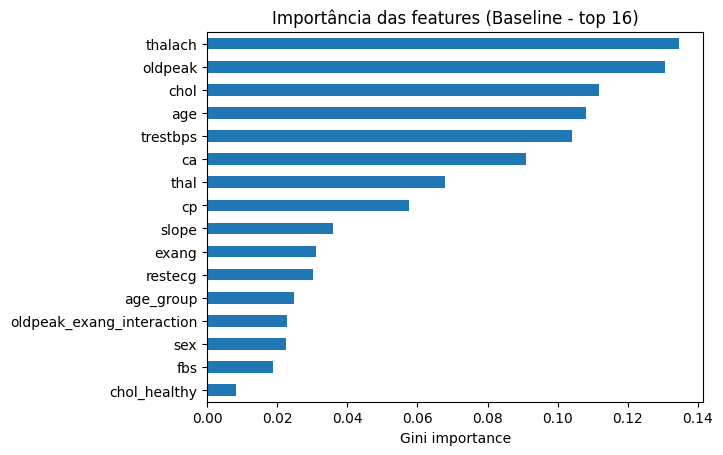

In [ ]:
rf.fit(X_encoded, y.values.ravel())
importances_base = pd.Series(rf.feature_importances_, index=X_encoded.columns).sort_values(ascending=False)

ax = importances_base.head(166).sort_values().plot.barh()
ax.set_title("Importância das features (Baseline - top 16)")
ax.set_xlabel("Gini importance")



1.   As variaveis mais revelantes são thalach(frequencia cardiaca maxima alcançada) e o oldpeak(alteração no esforco durante o descanso)
2.   Levando em considerações as features mais proeminentes sim eles aparentam ter relações
3.   Por mais que a deviation seja de 0.0396 ela ainda é maior q o modelo 0 oque pode ser um indicativo de noise
4.   A sua falta de precisão e desvio podem causar falsa segurança ou insegurança aos passientes

